# Pacote de Onda Plana

Neste *notebook* verificamos a qualidade da evolução temporal de um pacote de onda gaussiano realizada por três diferentes métodos numéricos:

- Pseudo-Espectral (*Split-Step FFT*)
- Runge-Kutta
- Crank-Nicolson

## Bibliotecas utilizadas

In [1]:
# python standard
import os
import time
# from multiprocessing import Pool, TimeoutError

# third-party
import numpy as np
import pandas as pd
from scipy.stats import norm, skewnorm
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

# locals
from core.constantes import *
from core.utilidades import *
from core.onda_plana import evolucao_analitica, evolucao_numerica

## Configurações gráficas

In [2]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('mestrado')

## Parâmetros de qualidade

Vamos exemplificar abaixo dois dos parâmetros de qualidade:

- dispersão ou devio padrão
- obliquidade ou *skewness*

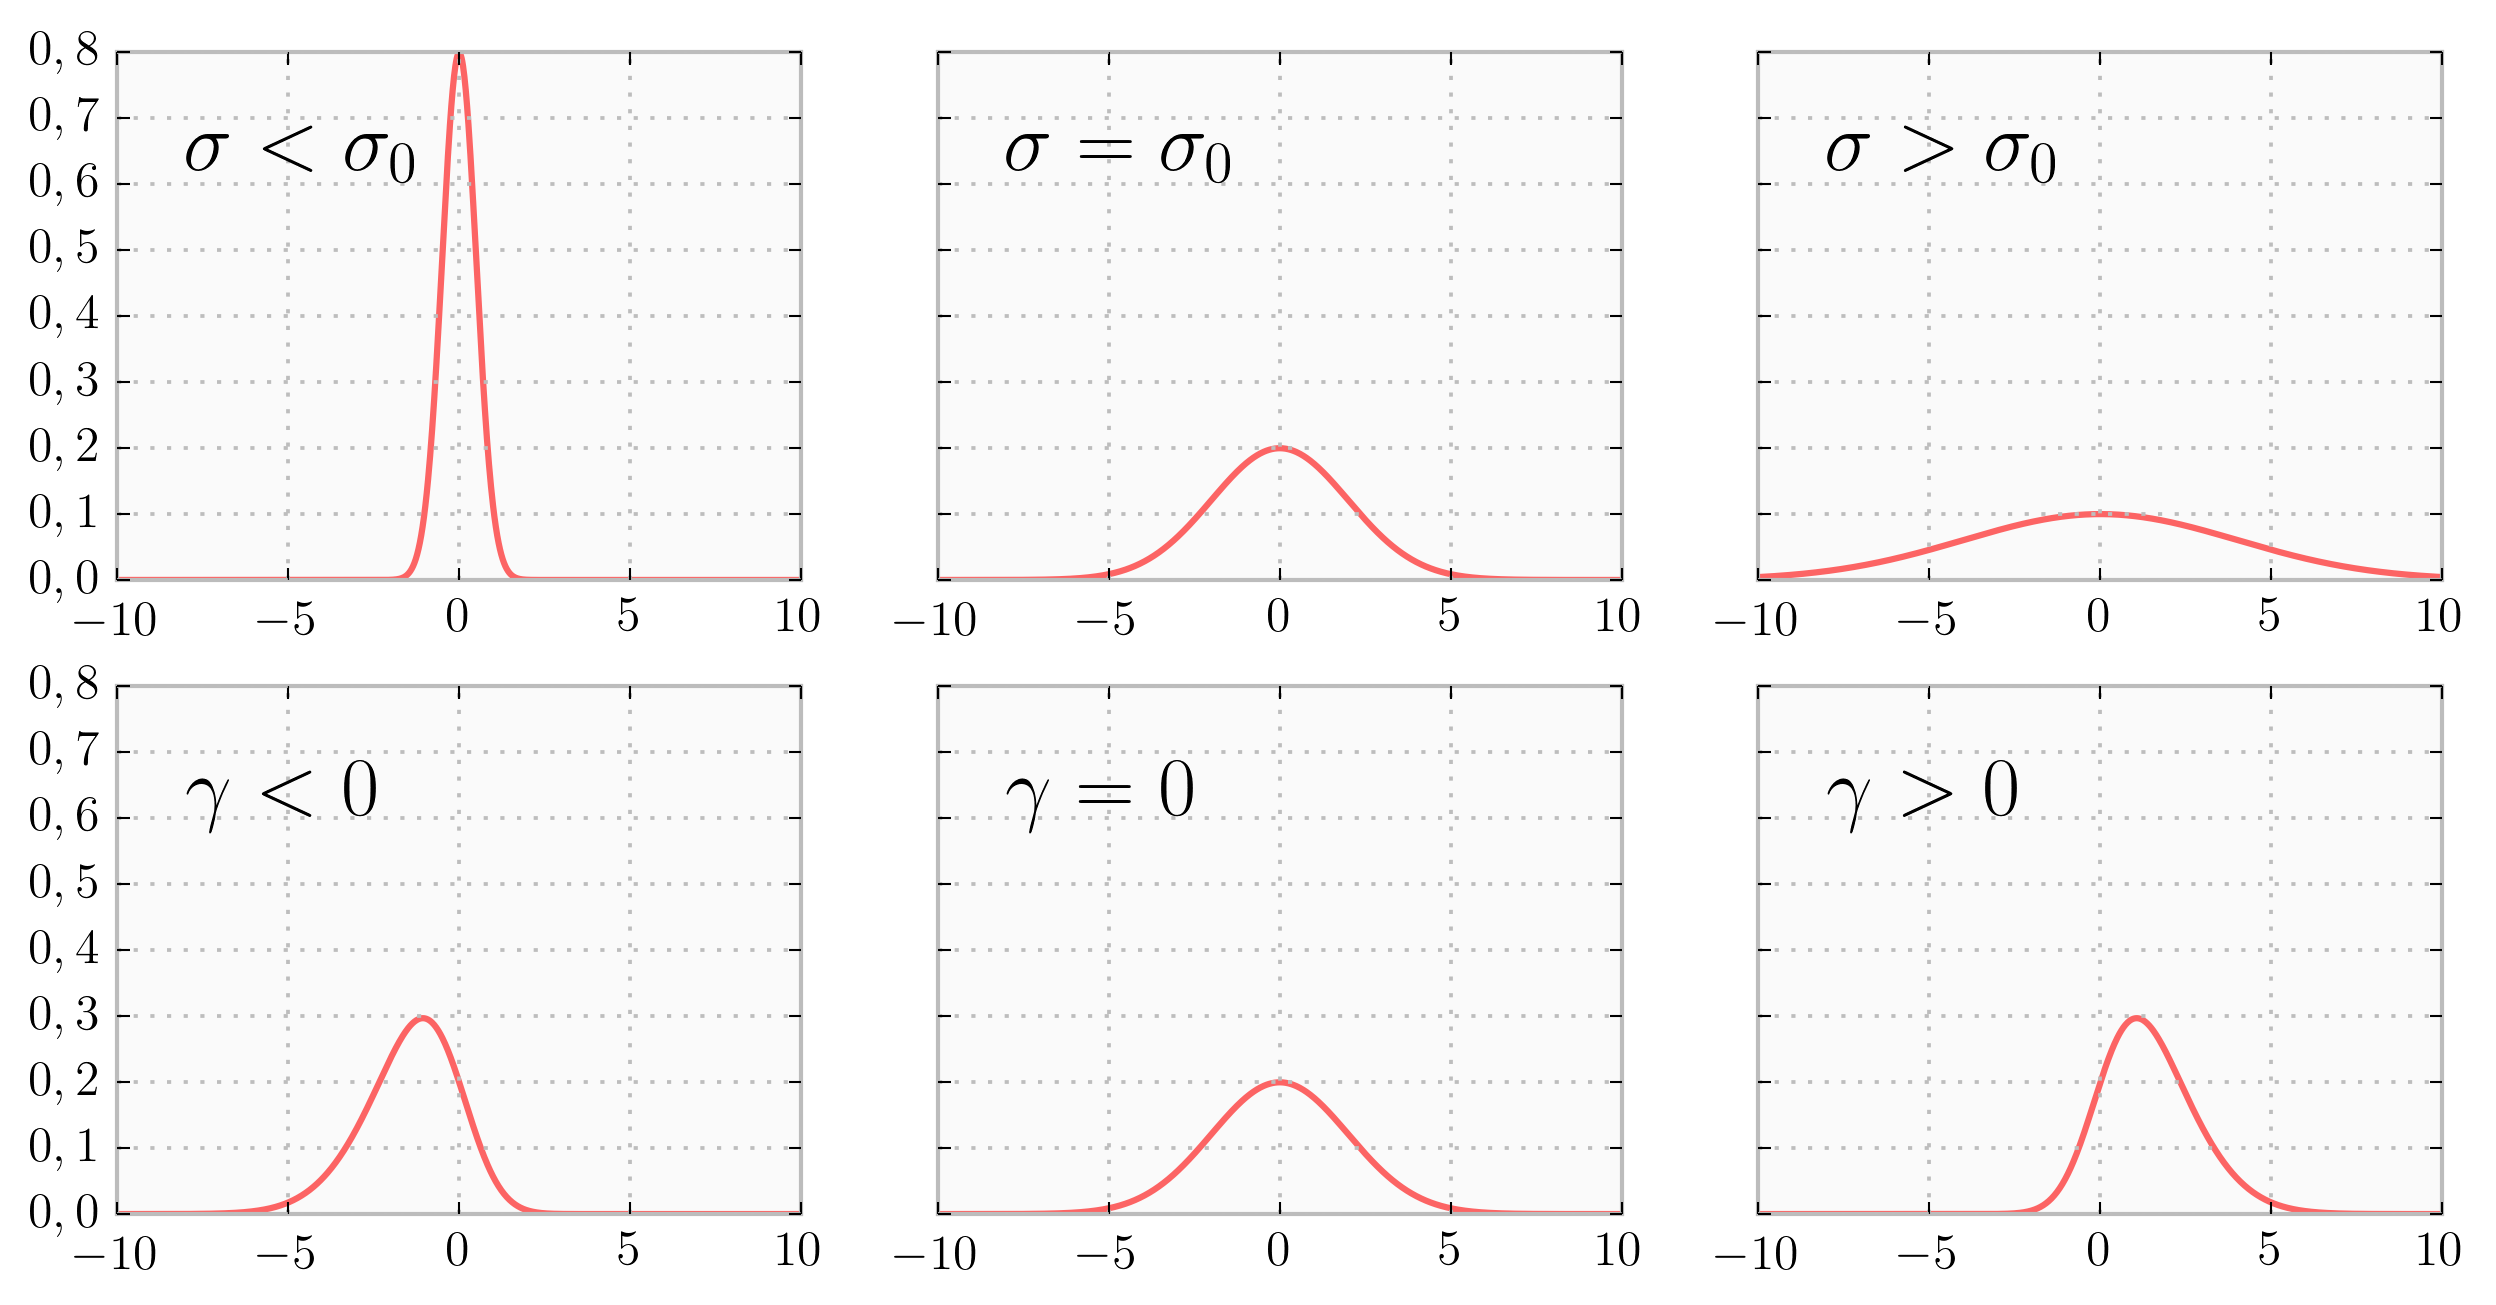

In [3]:
x = np.linspace(-10, 10, 1000)
df = pd.DataFrame({
    'x': x,
    'low_standard_deviation': norm.pdf(x, loc=0, scale=0.5),
    'normal_standard_deviation': norm.pdf(x, loc=0, scale=2.0),
    'high_standard_deviation': norm.pdf(x, loc=0, scale=4.0),
    'negative_skewness': skewnorm.pdf(x, -2, loc=0, scale=2.0),
    'zero_snewness': skewnorm.pdf(x, 0, loc=0, scale=2.0),
    'positive_skewness': skewnorm.pdf(x, 2, loc=0, scale=2.0)
})

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True)
mean, var, skew, kurt = norm.stats(moments='mvsk')
ax1.plot(x, norm.pdf(x, loc=0, scale=0.5), 'r-', alpha=0.6,
         label='norm pdf')
ax1.text(-8, 0.6, r"$\sigma < \sigma_0$")
ax2.plot(x, norm.pdf(x, loc=0, scale=2.0), 'r-', alpha=0.6,
         label='norm pdf')
ax2.text(-8, 0.6, r"$\sigma = \sigma_0$")
ax3.plot(x, norm.pdf(x, loc=0, scale=4.0), 'r-', alpha=0.6,
         label='norm pdf')
ax3.text(-8, 0.6, r"$\sigma > \sigma_0$")

ax4.plot(x, skewnorm.pdf(x, -2, loc=0, scale=2.0),
         'r-', alpha=0.6, label='norm pdf')
ax4.text(-8, 0.6, r"$\gamma < 0$")
ax5.plot(x, skewnorm.pdf(x, 0, loc=0, scale=2.0),
         'r-', alpha=0.6, label='norm pdf')
ax5.text(-8, 0.6, r"$\gamma = 0$")
ax6.plot(x, skewnorm.pdf(x, 2, loc=0, scale=2.0),
         'r-', alpha=0.6, label='norm pdf')
ax6.text(-8, 0.6, r"$\gamma > 0$")
plt.savefig('figuras/comparacao_desvpad_obliquidade.png')

# Evolução analítica

In [4]:
# na verdade já são os valores padrão, colocamos aqui para usar na
# construção do gráfico a seguir
zi = -20.0
zf = 20
E = 150.0
deltaz = 5.0
L = 150.0
N = 4096
res = evolucao_analitica(zi=zi, zf=zf, E=E, deltaz=deltaz, L=L, N=N)

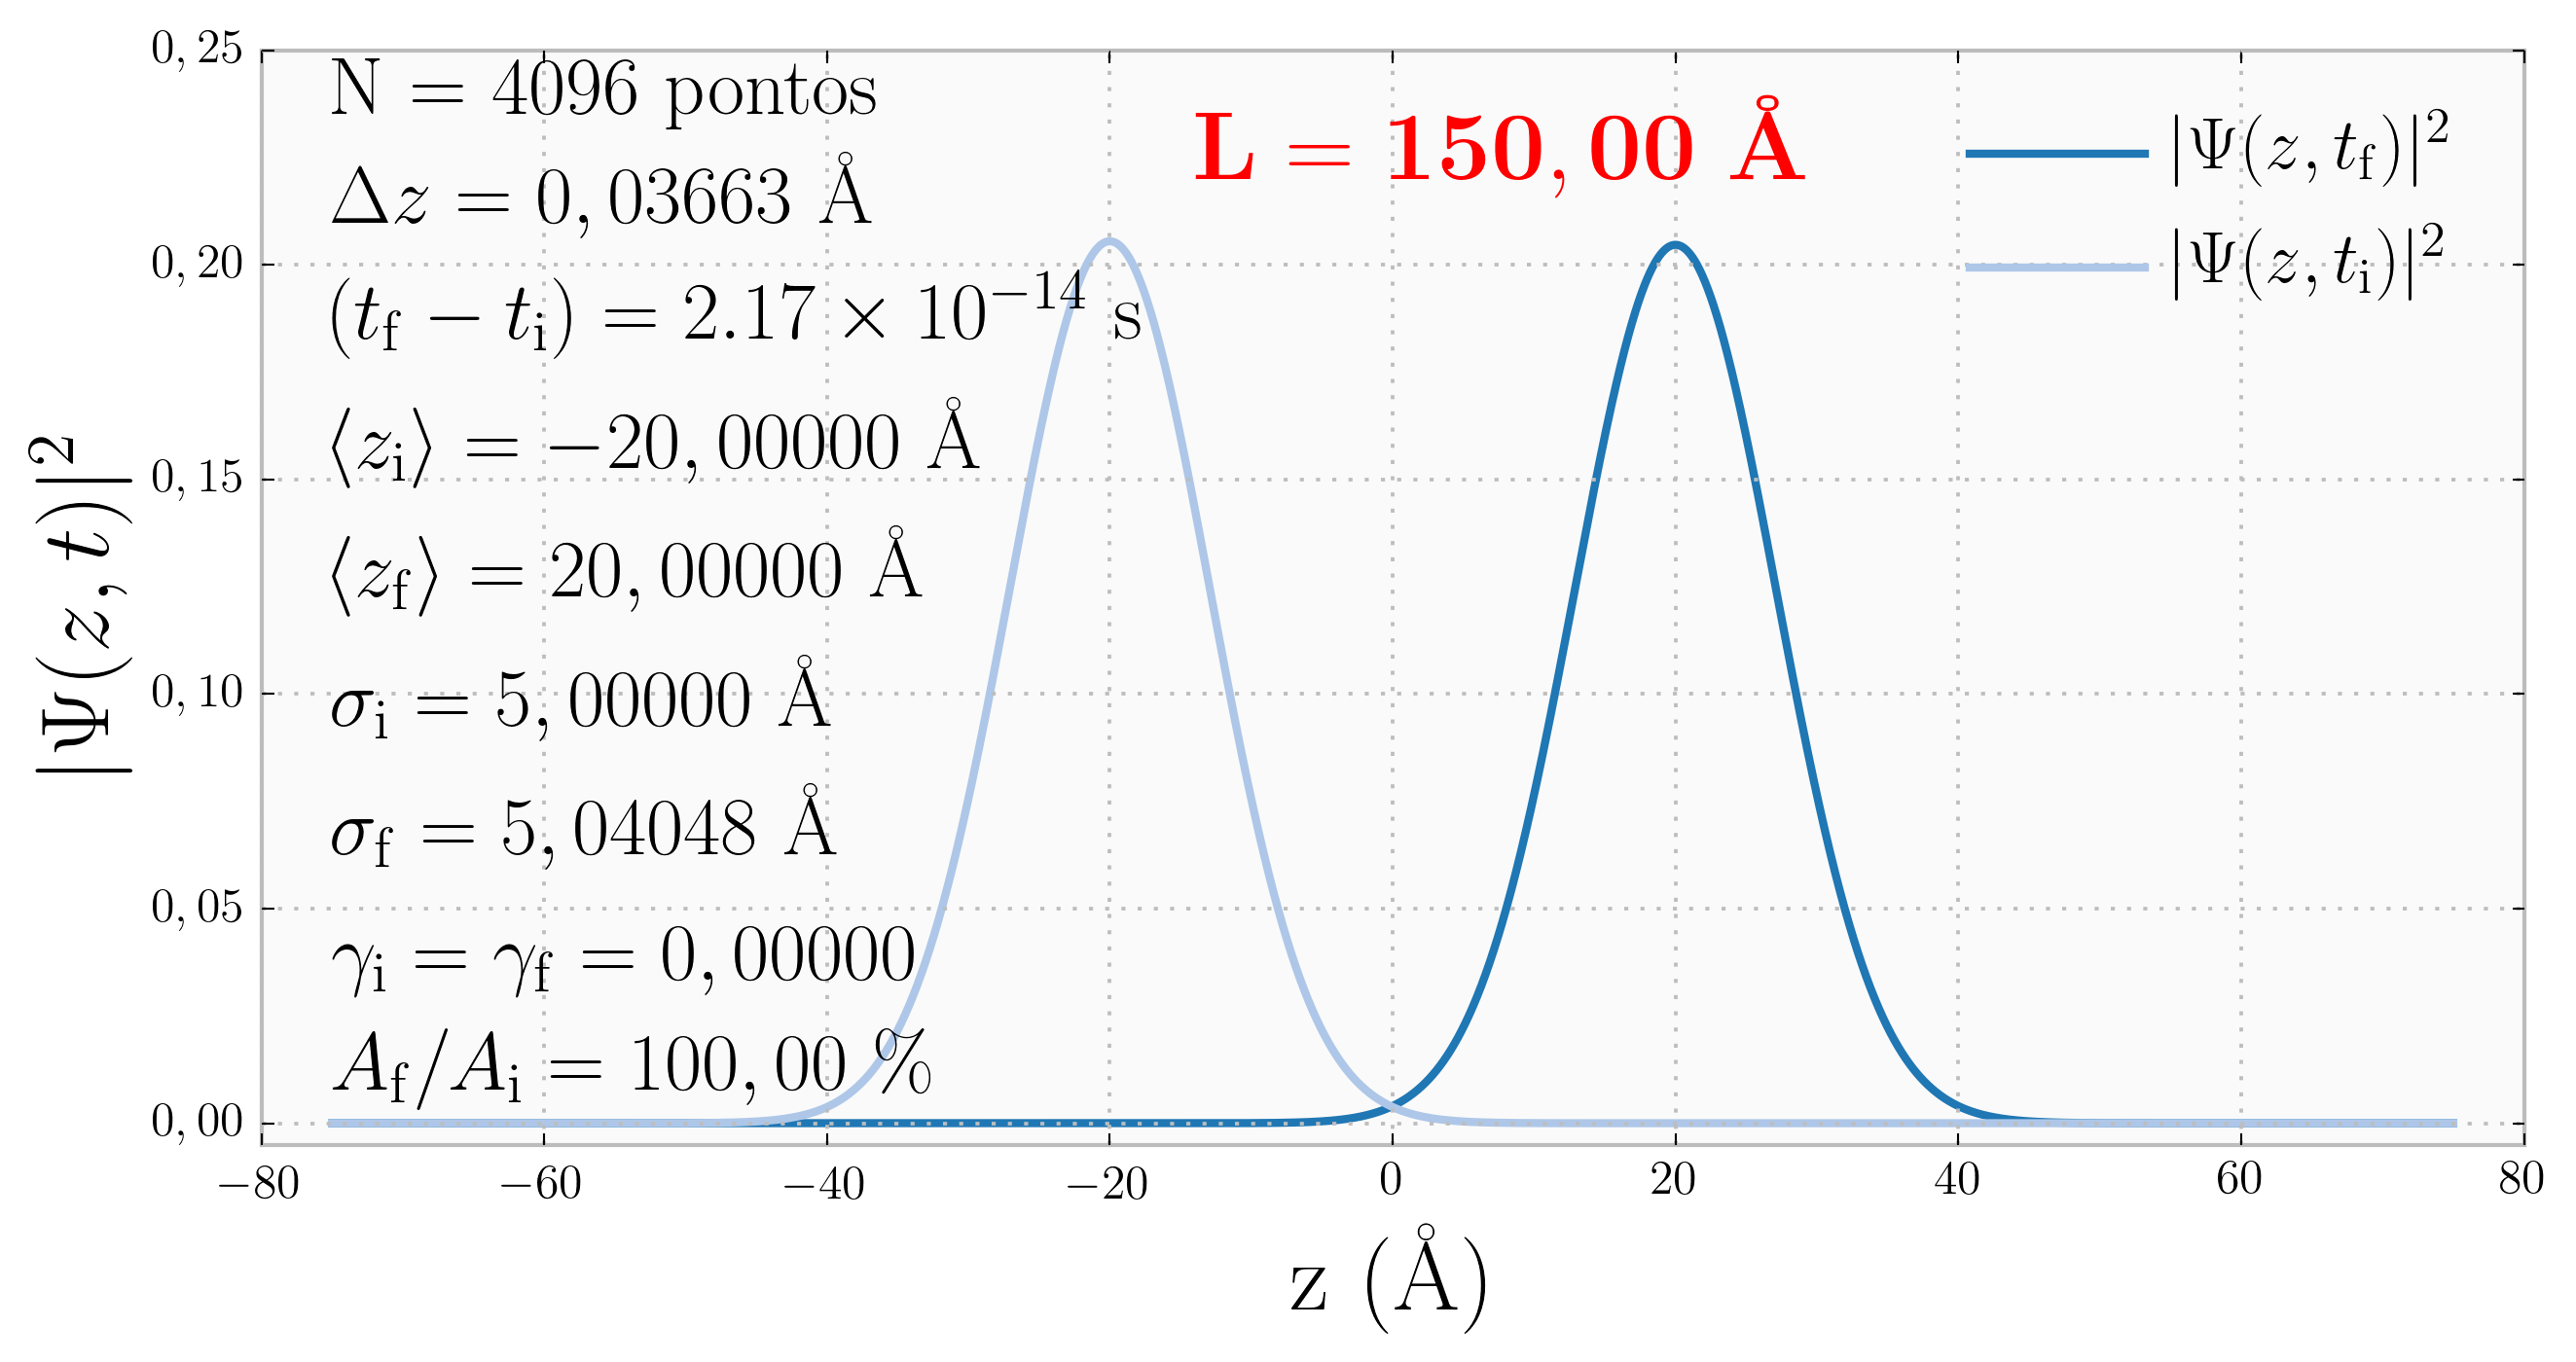

In [5]:
dz = res['z_ang'][1]-res['z_ang'][0]
t_au = res['tempo'] / au_t
texto_z = -L/2

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([-0.005, 0.25])
ax.text(-14, 0.22, dummy_comma(
    r"$\mathbf{L = %.2f}$ \textbf{\AA}" % (L)), color='red', fontsize=24)
ax.text(texto_z, 0.235, r"N = %d pontos" % N)
ax.text(texto_z, 0.21, dummy_comma(r"$\Delta z = %.5f$ \AA" % (dz)))
ax.text(texto_z, 0.18, dummy_comma(
    r"$(t_\mathrm{f}-t_\mathrm{i}) = %s$ s" % (as_si(t_au * au_t, 2))))
ax.text(texto_z, 0.15, dummy_comma(
    r"$\langle z_\mathrm{i} \rangle = %.5f$ \AA" % (zi)))
ax.text(texto_z, 0.12, dummy_comma(
    r"$\langle z_\mathrm{f} \rangle = %.5f$ \AA" % (res['zf_real'])))
ax.text(texto_z, 0.09, dummy_comma(
    r"$\sigma_\mathrm{i} = %.5f$ \AA" % (deltaz)))
ax.text(texto_z, 0.06, dummy_comma(
    r"$\sigma_\mathrm{f} = %.5f$ \AA" % (res['stdev'])))
ax.text(texto_z, 0.03, dummy_comma(
    r"$\gamma_\mathrm{i} = \gamma_\mathrm{f} = %.5f$" % np.abs(res['skewness'])))
ax.text(texto_z, 0.005, dummy_comma(
    r"$A_\mathrm{f}/A_\mathrm{i} = %.2f$ \%%" % (res['conservation'])))
plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel("z (\AA)", fontsize=24)
plt.ylabel(r'$|\Psi (z,t)|^2$', fontsize=24)
line1, = plt.plot(res['z_ang'], np.abs(res['wave_final']),
                  lw=2.0, color=(31 / 255, 119/255, 180/255),
                  label='$|\Psi(z,t_\mathrm{f})|^2$')
line2, = plt.plot(res['z_ang'], np.abs(res['wave_initial']), lw=2.0,
                  color=(174 / 255, 199/255, 232/255),
                  label='$|\Psi(z,t_\mathrm{i})|^2$')
plt.legend(handles=[line1, line2], loc=1)
plt.savefig('figuras/evolucao_pseudo_analitica.png')

# Evolução numérica

In [ ]:
methods = ['pe', 'cn', 'rk']
steps = [1e-20, 5e-20, 1e-19, 5e-19, 1e-18, 5e-18, 1e-17, 5e-17, 1e-16, 5e-16]
combs = []

for L in np.linspace(100,1000,7):
    for N in [2**n for n in range(8,13)]:
        for dt in steps:
            combs.append((L, N, dt))

res_ana_dict = {}
                
def evolui_combinacao(combination, method):
    try:
        # method, L, N, dt = combination
        L, N, dt = combination
        dz = float(L) / float(N)
        if (dt < 1e-19 and method != 'pe'):
            raise Exception("dt={} muito pequeno para [{}]".format(dt, method))
        elif dz >= 0.8:
            raise Exception("dz={:.3f} muito grande".format(dz))

        res = evolucao_numerica(L=L, N=N, dt=dt, method=method)
        zf_real = res['zf_real']
        if res['program_time'] > 300.0:
            raise Exception("Demorou mais de 300 segundos")
        elif not (-L/2 <= zf_real <= L/2):
            raise Exception("Foi parar fora da malha")
        elif zf_real == -20.0:
            raise Exception("Não se moveu")
        elif zf_real == -20.0:
            raise Exception("Andou para o lado errado")
        
        try:
            res_ana = res_ana_dict[(zf_real, L, N)]
        except:
            res_ana = evolucao_analitica(zf=zf_real, L=L, N=N)
            res_ana_dict[(zf_real, L, N)] = res_ana
            
        for k in res_ana.keys():
            res[k + '_ana'] = res_ana[k]
        message = "%s: L=%d, N=%d, dt=%.2e, " + \
            "A/A0=%.5f, S=%.4f, G=%.4f, time=%.5f"
        message = message % (method, L, N, dt,
                             res['conservation'], res['stdev'],
                             res['skewness'], res['program_time'])
        print(message)
        return res
    except Exception as err:
        print(err)
        print("Falha em %s: L=%d, N=%d, dt=%.2e" % (method, L, N, dt))
        return {}


# pool = Pool(processes=2)
# results = pd.DataFrame(pool.map(evolui_combinacao, combs))

# colunas para serem salvas
cols = ['E', 'E_ana', 'L', 'L_ana', 'N', 'N_ana', 'a_final', 'a_final_ana',
        'a_initial', 'a_initial_ana', 'conservation', 'conservation_ana',
        'deltaz', 'deltaz_ana', 'dt', 'iterations', 'method', 'program_time',
        'skewness', 'skewness_ana', 'stdev', 'stdev_ana', 'time_ana']

for method in methods:
    ms = [method] * len(combs)
    results = pd.DataFrame(list(map(evolui_combinacao, combs, ms))).dropna()
    results[cols].to_csv('saidas/onda_plana_resultados_{}.csv'.format(
        method), sep=",", index=False)

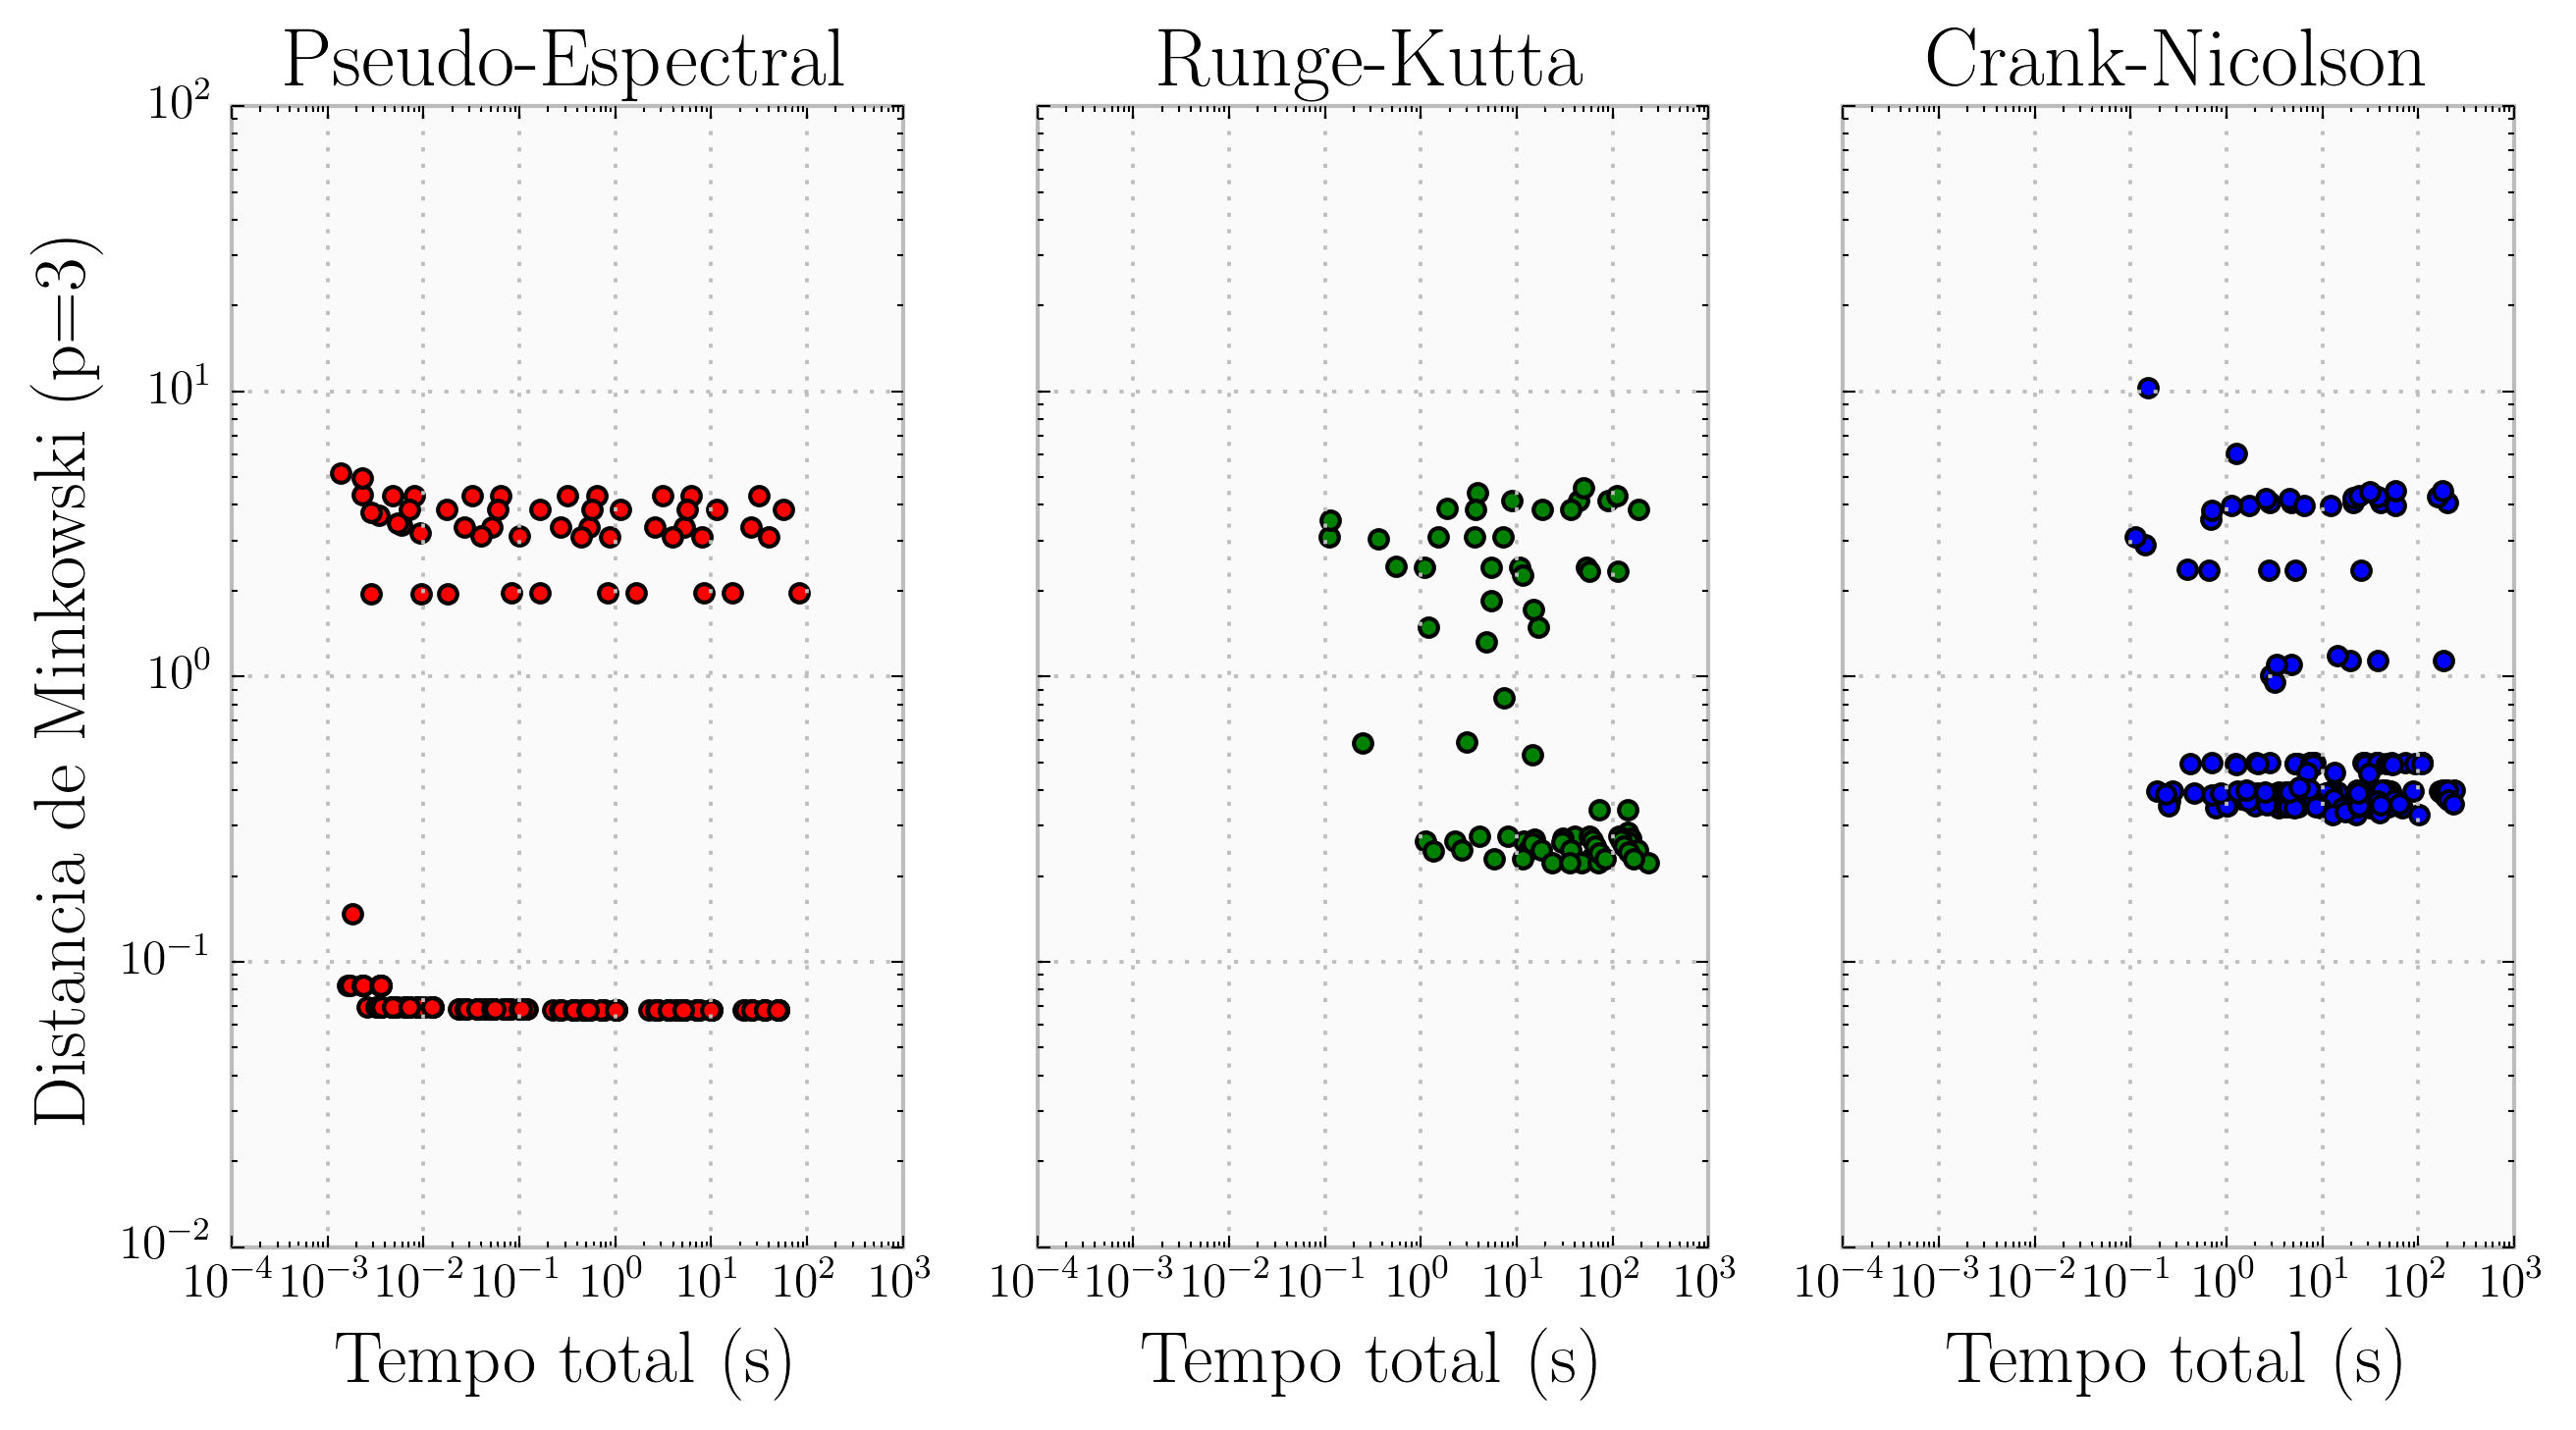

In [6]:
pe = pd.read_csv('saidas/onda_plana_resultados_pe.csv')
rk = pd.read_csv('saidas/onda_plana_resultados_rk.csv')
cn = pd.read_csv('saidas/onda_plana_resultados_cn.csv')

pec = pe.copy()
rkc = rk.copy()
cnc = cn.copy()

scaler = StandardScaler()
cols = ['stdev', 'skewness', 'a_final', 'stdev_ana', 'skewness_ana',
        'a_final_ana']

pec[cols] = scaler.fit_transform(pec[cols])
rkc[cols] = scaler.fit_transform(rkc[cols])
cnc[cols] = scaler.fit_transform(cnc[cols])

p = 3
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True);

with pd.plotting.plot_params.use('x_compat', True):
    pec['minkowski'] = pec.apply(lambda l: cdist(XA=[[l.a_final,l['stdev'],
                                                      l['skewness']]],
                                                 XB=[[l.a_final_ana,
                                                      l.stdev_ana,
                                                      l.skewness_ana]],
                                                 metric='minkowski',
                                                 p=p)[0][0], axis=1)
    pec.plot(x='program_time', y='minkowski', kind='scatter', loglog=True,
             color='r', ax=ax1, sharex=True, sharey=True)

    rkc['minkowski'] = rkc.apply(lambda l: cdist(XA=[[l.a_final,l['stdev'],
                                                      l['skewness']]],
                                                 XB=[[l.a_final_ana,
                                                      l.stdev_ana,
                                                      l.skewness_ana]],
                                                 metric='minkowski',
                                                 p=p)[0][0], axis=1)
    rkc.plot(x='program_time', y='minkowski', kind='scatter', loglog=True,
             color='g', ax=ax2, sharex=True, sharey=True)
    cnc['minkowski'] = cnc.apply(lambda l: cdist(XA=[[l.a_final,l['stdev'],
                                                      l['skewness']]],
                                                 XB=[[l.a_final_ana,
                                                      l.stdev_ana,
                                                      l.skewness_ana]],
                                                 metric='minkowski',
                                                 p=p)[0][0], axis=1)
    cnc.plot(x='program_time', y='minkowski', kind='scatter', loglog=True,
             color='b', ax=ax3, sharex=True, sharey=True)

ax1.title.set_text('Pseudo-Espectral')
ax2.title.set_text('Runge-Kutta')
ax3.title.set_text('Crank-Nicolson')
ax1.set_ylabel('Distancia de Minkowski (p=3)')
ax2.set_ylabel('Distancia de Minkowski (p=3)')
ax3.set_ylabel('Distancia de Minkowski (p=3)')
ax1.set_xlabel('Tempo total (s)')
ax2.set_xlabel('Tempo total (s)')
ax3.set_xlabel('Tempo total (s)')

plt.savefig('figuras/onda_plana_comparacao_minkowski.png', bbox_inches='tight')